In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import math
from time import time


%matplotlib inline

In [4]:
import os, pickle
import pickle

def cifar10(data_path):

    def _load_data_(files):
        X = np.empty([0, 3072])
        y = np.empty([0])
        for path in files:
            print(path)
            with open(path, "rb") as f:
                d = pickle.load(f, encoding='bytes')
                X = np.vstack([X, d[b"data"]]).astype("uint8")
                y = np.hstack([y, d[b"labels"]]).astype("uint8")
        return X, y
    
    training_files = [os.path.join(data_path, "data_batch_{0}".format(i))  for i in range(1, 6)]
    test_files = [os.path.join(data_path, "test_batch")]
    labels_file = os.path.join(data_path, "batches.meta")

    X_train, y_train = _load_data_(training_files)
    X_test, y_test = _load_data_(test_files)

    X_train = X_train.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255
    X_test = X_test.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255

    with open(labels_file, "rb") as f:
        labels = pickle.load(f, encoding="bytes")
    labels = [s.decode("utf-8")  for s in labels[b'label_names']]
    return X_train, X_test, y_train, y_test, labels

X_train, X_test, y_train, y_test, labels = cifar10("/Users/abasar/data/cifar-10-batches-py")
print("X_train:", X_train.shape, 
      "\nX_test:", X_test.shape, 
      "\ny_train: ", y_train.shape, 
      "\ny_test:", y_test.shape, 
      "\nlabels: ", labels)

/Users/abasar/data/cifar-10-batches-py/data_batch_1
/Users/abasar/data/cifar-10-batches-py/data_batch_2
/Users/abasar/data/cifar-10-batches-py/data_batch_3
/Users/abasar/data/cifar-10-batches-py/data_batch_4
/Users/abasar/data/cifar-10-batches-py/data_batch_5
/Users/abasar/data/cifar-10-batches-py/test_batch
X_train: (50000, 32, 32, 3) 
X_test: (10000, 32, 32, 3) 
y_train:  (50000,) 
y_test: (10000,) 
labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
pd.Series(y_test).value_counts()

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
dtype: int64

In [6]:
Y_train = keras.utils.to_categorical(y_train)
Y_test = keras.utils.to_categorical(y_test)
Y_train.shape, Y_test.shape

((50000, 10), (10000, 10))

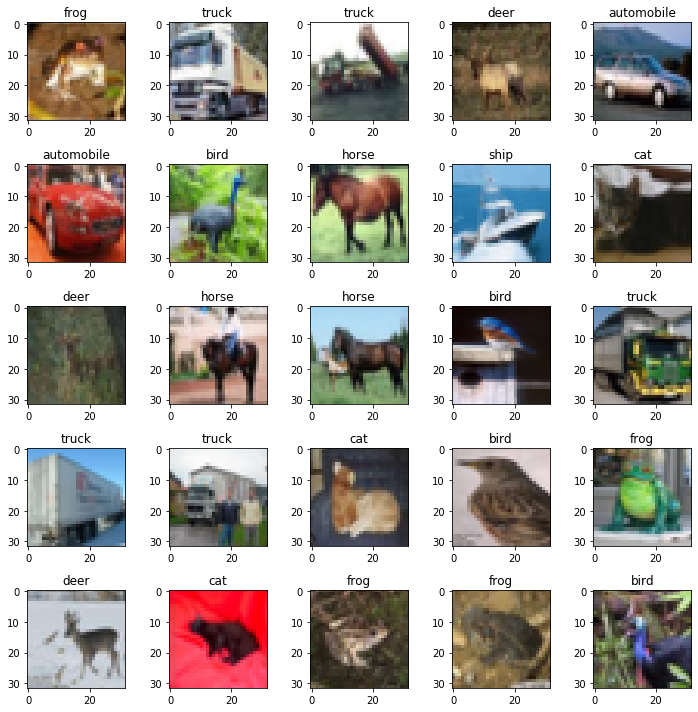

In [7]:
fig, _ = plt.subplots(5, 5, figsize= (10, 10))

for i, ax in enumerate(fig.axes):
    ax.imshow(X_train[i])
    label = labels[y_train[i]]
    ax.set_title(label)
    
plt.tight_layout()

Let's take a look at differente horse images

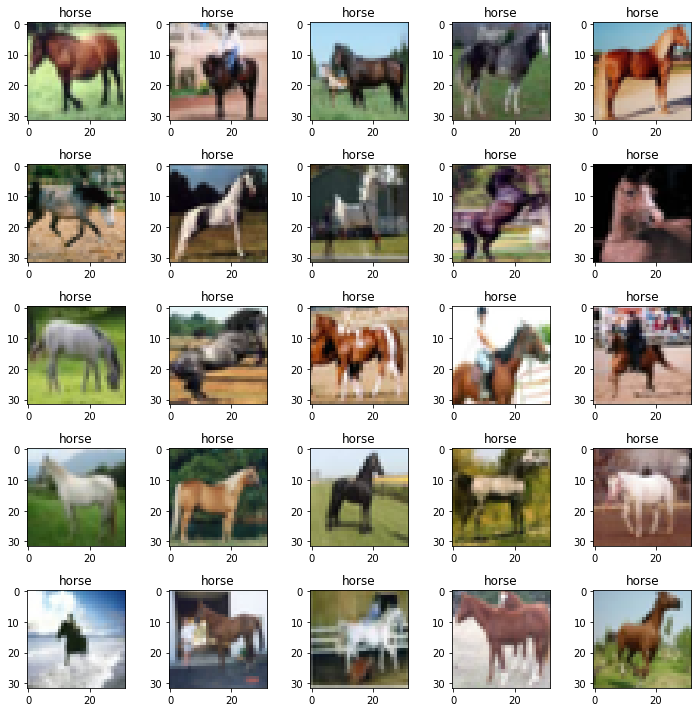

In [8]:
fig, _ = plt.subplots(5, 5, figsize= (10, 10))

for i, ax in enumerate(fig.axes):
    data_filter = y_train == 7
    ax.imshow(X_train[data_filter][i])
    label = labels[y_train[data_filter][i]]
    ax.set_title(label)
    
plt.tight_layout()

# LetNet Architecture

In [11]:
input_shape = (32, 32, 3)

In [16]:
tensorboard = keras.callbacks.TensorBoard(log_dir="/tmp/tf/" + str(int(time())))

#tf.set_random_seed(1)
np.random.seed(1)
num_classes = len(labels)

def build_model(input_shape, num_classes):
    with tf.device('/cpu:0'):
        model = keras.Sequential()
        model.add(layers.Conv2D(activation="relu", 
                                filters=32, 
                                kernel_size=(5, 5), 
                                input_shape = input_shape))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Conv2D(activation="relu", 
                            filters=64, 
                            kernel_size=(5, 5)))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dropout(rate=0.4))
        model.add(layers.Dense(400, activation="relu"))
        model.add(layers.Dense(num_classes, activation="softmax"))
        model.compile(loss=keras.losses.categorical_crossentropy
                      , metrics=["accuracy"]
                      , optimizer="adam")
    return model

model = build_model(input_shape, num_classes)
model.summary()

model.fit(x=X_train
          , y = Y_train
          , validation_data = (X_test, Y_test)
          , batch_size = 16
          , epochs=10
          , callbacks = [tensorboard]
         )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               6

# AlexNet Architecture

# Training with image augmentation

In [21]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
tensorboard = keras.callbacks.TensorBoard(log_dir="/tmp/tf/" + str(int(time())))

shape = X_train.shape[1:]


def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate
 
    
    
weight_decay = 1e-4
model = keras.Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation="relu", kernel_regularizer=regularizers.l2(weight_decay), input_shape=shape))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation="relu", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', activation="relu", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation="relu", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', activation="relu", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation="relu", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()
 
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)
 
#training
batch_size = 64
 
# opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
adam = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size)
                    , steps_per_epoch=X_train.shape[0] // batch_size
                    , epochs=5
                    , verbose=1
                    , validation_data=(X_test, Y_test)
                    , callbacks=[LearningRateScheduler(lr_schedule), tensorboard])
#save to disk
model_json = model.to_json()
with open('/tmp/model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('/tmp/model.h5') 
 
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)       

As we can see aftre 150 iterations still has not got saturation. More epochs will improve the performance of this model.